## Predicting whether the given news is fake news or an original one.

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting  whether the given news is a fake news or an original one.


**1. Problem Definition**         
In a statement,         
The problem we will be exploring is binary classification (a sample can only be one of two things).     

You have to use the data provided by the client to build a model to predict whether a news is fake or not fake   

**2. Data**       
All of the dataset values were provided by a client.      

**3. Evaluation**       
Evaluating a models predictions using problem-specific evaluation metrics          

**4. Features**        
There are 5 features in the dataset provided. The description of each of the feature is given below:   
“id”:  Unique id of each news article          
“headline”:  It is the title of the news.                
“news”:  It contains the full text of the news article           
“Unnamed:0”:  It is a serial number                           
“written_by”:  It represents the author of the news article             

**5. label**                                                      
“label”:  It tells whether the news is fake (1) or not fake (0).               



In [1]:
# importing useful librarier for the data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
# packages from gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer

#packages from nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag
from collections import Counter
import warnings 
warnings.filterwarnings('ignore')


In [56]:
# Loading the dataset
df_news=pd.read_csv('train_news.csv')
df_news

,Unnamed: 0,id,headline,written_by,news,label
0,0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1
...,...,...,...,...,...,...
20795,20795,5671,NaN,NeverSurrender,"No, you'll be a dog licking of the vomit of yo...",1
20796,20796,14831,Albert Pike and the European Migrant Crisis,Rixon Stewart,"By Rixon Stewart on November 5, 2016 Rixon Ste...",1
20797,20797,18142,Dakota Access Caught Infiltrating Protests to ...,Eddy Lavine,posted by Eddie You know the Dakota Access Pip...,1
20798,20798,12139,How to Stretch the Summer Solstice - The New Y...,Alison S. Cohn,"It’s officially summer, and the Society Boutiq...",0


In [57]:
# checking the features,duplicate values and nan values in the Datasets

print("\nFeatures Present in the Dataset: \n", df_news.columns)
shape=df_news.shape
print("\nTotal Number of Rows : ",shape[0])
print("Total Number of Features : ", shape[1])
print("\n\nData Types of Features :\n", df_news.dtypes)
print("\nDataset contains any NaN/Empty cells : ", df_news.isnull().values.any())
print("\nTotal number of empty rows in each feature:\n", df_news.isnull().sum(),"\n\n")
print("Total number of unique values in each feature:")
for col in df_news.columns.values:
    print("Number of unique values of {} : {}".format(col, df_news[col].nunique()))
    
print ('\nFake News and NOT Fake News counts','\n',df_news.label.value_counts())



Features Present in the Dataset: 
 Index(['Unnamed: 0', 'id', 'headline', 'written_by', 'news', 'label'], dtype='object')

Total Number of Rows :  20800
Total Number of Features :  6


Data Types of Features :
 Unnamed: 0     int64
id             int64
headline      object
written_by    object
news          object
label          int64
dtype: object

Dataset contains any NaN/Empty cells :  True

Total number of empty rows in each feature:
 Unnamed: 0       0
id               0
headline       558
written_by    1957
news            39
label            0
dtype: int64 


Total number of unique values in each feature:
Number of unique values of Unnamed: 0 : 20800
Number of unique values of id : 20800
Number of unique values of headline : 19803
Number of unique values of written_by : 4201
Number of unique values of news : 20386
Number of unique values of label : 2

Fake News and NOT Fake News counts 
 1    10413
0    10387
Name: label, dtype: int64


In [58]:
# Dropping features which are not giving any useful information
df_news.drop(['Unnamed: 0','id'],axis=1,inplace=True)

In [59]:
# Feature subject is having some null values, in here I am 
# filling 'Written_by' feature with unknown because sometimes there are anonymus authors,...
# filling up empty values in 'headline' feature as i will merge it further for further processing...
# Dropping empty values in rows because we are detecting fake news here and for this news is needed..

df_news['written_by'].fillna('Unknown ',inplace=True)
df_news['headline'].fillna(' ',inplace=True)
df_news.dropna(subset=['news'],inplace=True)
df_news.head()

,headline,written_by,news,label
0,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [60]:
# Checking null values...
df_news.isnull().sum()

headline      0
written_by    0
news          0
label         0
dtype: int64

In [61]:
# Checking shape...
df_news.shape

(20761, 4)

In [62]:
# As we all know that news and headline both are important for authenticity detection,
# thus here I am joining both news and headline features to get some useful information while training...  
df_news['Content'] = df_news[['headline', 'news']].apply(lambda x: ' '.join(x), axis = 1)
df_news

,headline,written_by,news,label,Content
0,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,Ethics Questions Dogged Agriculture Nominee as...
1,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,U.S. Must Dig Deep to Stop Argentina’s Lionel ...
2,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0,Cotton to House: ’Do Not Walk the Plank and Vo...
3,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,"Paul LePage, Besieged Maine Governor, Sends Co..."
4,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1,A Digital 9/11 If Trump Wins Finian Cunningh...
...,...,...,...,...,...
20795,,NeverSurrender,"No, you'll be a dog licking of the vomit of yo...",1,"No, you'll be a dog licking of the vomit of ..."
20796,Albert Pike and the European Migrant Crisis,Rixon Stewart,"By Rixon Stewart on November 5, 2016 Rixon Ste...",1,Albert Pike and the European Migrant Crisis By...
20797,Dakota Access Caught Infiltrating Protests to ...,Eddy Lavine,posted by Eddie You know the Dakota Access Pip...,1,Dakota Access Caught Infiltrating Protests to ...
20798,How to Stretch the Summer Solstice - The New Y...,Alison S. Cohn,"It’s officially summer, and the Society Boutiq...",0,How to Stretch the Summer Solstice - The New Y...


In [63]:
# New feature (length) contains length of the content feature..
df_news['length'] = df_news.Content.str.len()
df_news.head()

,headline,written_by,news,label,Content,length
0,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,Ethics Questions Dogged Agriculture Nominee as...,8021
1,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,6185
2,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0,Cotton to House: ’Do Not Walk the Plank and Vo...,526
3,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,"Paul LePage, Besieged Maine Governor, Sends Co...",6617
4,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1,A Digital 9/11 If Trump Wins Finian Cunningh...,9193


In [64]:
# Return the wordnet object value corresponding to the POS tag
#Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def clean_text(text):
    # lower text
    text = text.lower()
    text = re.sub("[^\w\s]", " ", text) 
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # Remove leading and trailing whitespace
    #text=re.sub("[^\s+|\s+?$]"," ",text)
    # remove stop words
    stop = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    #text=stemmer.stem(text)
    # remove words with only two letter
    text = [t for t in text if len(t) > 2]
    # join all
    text = " ".join(text)
    return(text)

In [65]:
# cleaning the news and storing them in a separate feature...
df_news["clean_content"] = df_news["Content"].apply(lambda x: Processed_data(x))

In [66]:
# checking the clean news content..
df_news["clean_content"]

0        ethic question dogged agriculture nominee geor...
1        deep stop argentina lionel messi york time hou...
2        cotton house walk plank vote senate breitbart ...
3        paul lepage besieged maine governor sends conf...
4        digital trump finian cunningham written extens...
                               ...                        
20795                       licking vomit chinese overlord
20796    albert pike european migrant crisis rixon stew...
20797    dakota access caught infiltrating protest inci...
20798    stretch summer solstice york time officially s...
20799    emory university percent undocumented student ...
Name: clean_content, Length: 20761, dtype: object

In [67]:
# New feature (Clean_length) contains length of the Clean_content feature after puncuations, stopwords removal..
df_news['Clean_length'] = df_news.clean_content.str.len()
df_news.head()

,headline,written_by,news,label,Content,length,clean_content,Clean_length
0,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,Ethics Questions Dogged Agriculture Nominee as...,8021,ethic question dogged agriculture nominee geor...,4872
1,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,6185,deep stop argentina lionel messi york time hou...,3675
2,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0,Cotton to House: ’Do Not Walk the Plank and Vo...,526,cotton house walk plank vote senate breitbart ...,258
3,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,"Paul LePage, Besieged Maine Governor, Sends Co...",6617,paul lepage besieged maine governor sends conf...,3928
4,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1,A Digital 9/11 If Trump Wins Finian Cunningh...,9193,digital trump finian cunningham written extens...,5902


In [68]:
# Tokenizing Documents..
data=[]
from nltk.tokenize import word_tokenize
for j,i in enumerate(df_news['clean_content']):
    a=word_tokenize(i,'english')
    data.append(a)

In [69]:
# Makin Word dictionary...
dictionary = corpora.Dictionary(data)
print(dictionary)

Dictionary(163884 unique tokens: ['1990s', '2003', '2004', '2005', '2006']...)


# EDA

In [70]:
# diplaying number of counts of labels....
df_news['label'].value_counts()

0    10387
1    10374
Name: label, dtype: int64

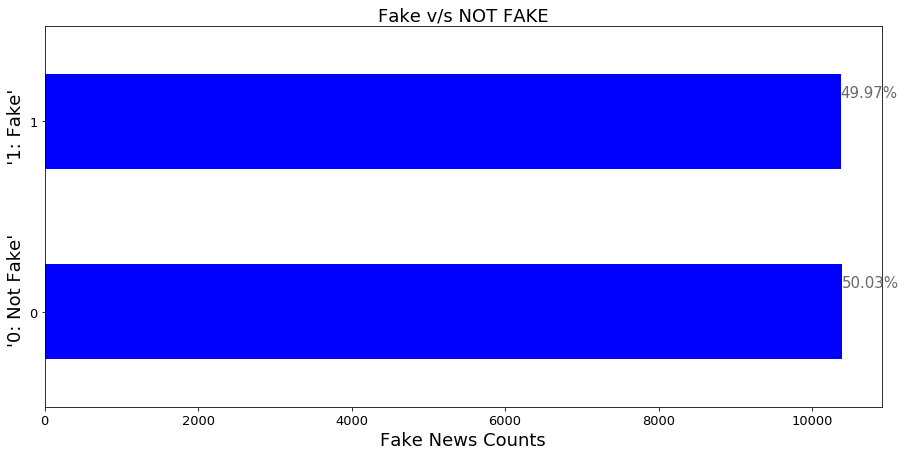

In [78]:
# Displaying the percentage of Fake and Not Fake news in the given dataset...
# Plotting graph using label values from the df_news dataframe

ax = df_news['label'].value_counts().plot(kind='barh', figsize=(15,7),color="blue", fontsize=13)
ax.set_alpha(0.8)

# Setting up title and labels
ax.set_title("Fake v/s NOT FAKE", fontsize=18)
ax.set_xlabel("Fake News Counts",  fontsize=18)
ax.set_ylabel("'0: Not Fake'            '1: Fake'", fontsize=18)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,color='dimgrey')

In [72]:
#for counting frequently occurence of fake and not fake words.
count1 = Counter(" ".join(df_news[df_news['label']==0]["clean_content"]).split()).most_common(200)
count2 = Counter(" ".join(df_news[df_news['label']==1]["clean_content"]).split()).most_common(200)
df=pd.DataFrame()
print("TOP 200 Words in Each Category (Word,Counts)")
df['Not Fake Words']=count1
df['Fake Words']=count2
df.head(10)

TOP 200 Words in Each Category (Word,Counts)


,Not Fake Words,Fake Words
0,"(said, 68223)","(trump, 21691)"
1,"(trump, 38444)","(clinton, 21168)"
2,"(time, 24451)","(people, 17065)"
3,"(state, 22767)","(state, 15634)"
4,"(year, 21785)","(hillary, 13817)"
5,"(people, 20122)","(time, 12812)"
6,"(president, 17515)","(year, 11978)"
7,"(like, 16413)","(said, 11911)"
8,"(york, 12903)","(american, 10800)"
9,"(american, 12192)","(like, 10668)"


In [79]:
# Making a wordcloud function in order to show the fake and NOT fake words from the dataset..
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def Display_wordcloud(data,title):
    feedbackcloud = WordCloud(
        background_color = 'white',
        max_words = 1000,
        max_font_size = 40, 
        scale = 3,
        random_state = 25
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15, 10),facecolor='g')
    plt.axis('off')
    plt.imshow(feedbackcloud)
    plt.title(f"{title} words")
    plt.show()

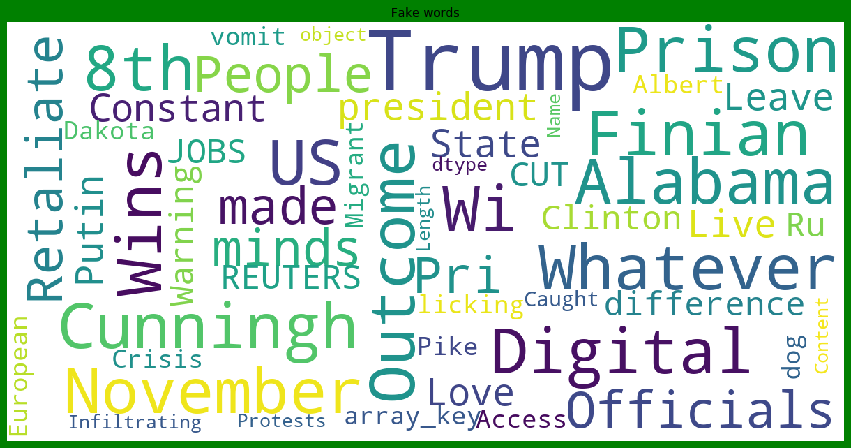

In [80]:
# SPAM words in training data
Display_wordcloud(df_news['Content'][df_news['label']==1],"Fake")

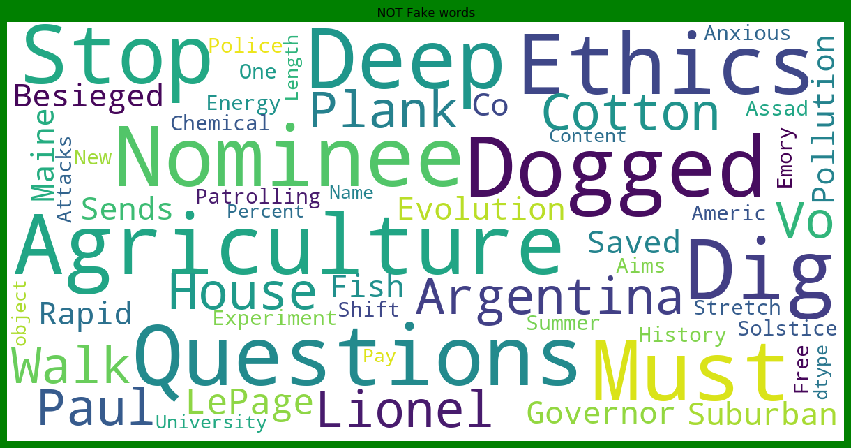

In [81]:
# NOT FAKE words in training data
Display_wordcloud(df_news['Content'][df_news['label']==0],"NOT Fake")

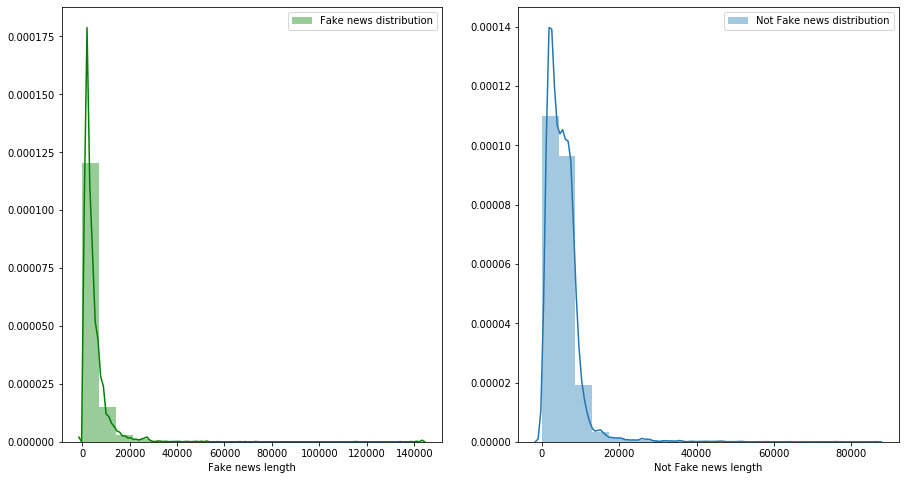

In [76]:
# Email distribution BEFORE cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_news[df_news['label']==1]['length'],bins=20,ax=ax[0],label='Fake news distribution',color='g')

ax[0].set_xlabel('Fake news length')
ax[0].legend()

sns.distplot(df_news[df_news['label']==0]['length'],bins=20,ax=ax[1],label='Not Fake news distribution')
ax[1].set_xlabel('Not Fake news length')
ax[1].legend()

plt.show()

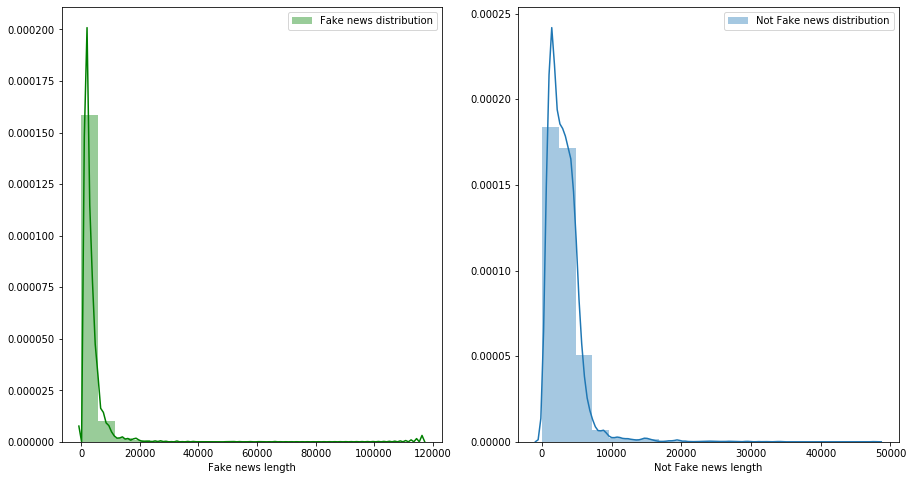

In [77]:
# Email distribution after cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_news[df_news['label']==1]['Clean_length'],bins=20,ax=ax[0],label='Fake news distribution',color='g')

ax[0].set_xlabel('Fake news length')
ax[0].legend()

sns.distplot(df_news[df_news['label']==0]['Clean_length'],bins=20,ax=ax[1],label='Not Fake news distribution')
ax[1].set_xlabel('Not Fake news length')
ax[1].legend()

plt.show()

In [26]:
# creating the TF-IDF(term frequency–inverse document frequency) vectorizer function in order to convert the tokens 
#   from the train documents into vectors so that machine can do further processing
def Tf_idf_train(text):
    tfid = TfidfVectorizer(min_df=3,smooth_idf=False)
    return tfid.fit_transform(text)

In [27]:
# Inserting vectorized values in a variable x, which will be used in training the model 
x=Tf_idf_train(df_news['clean_content'])

In [28]:
# checking the shape of the data which is inserted in x which will be used for model training.
print("Shape of x: ",x.shape)

# Assigning the label in y and checking it's shape
y = df_news['label'].values
print("Shape of y: ",y.shape)

Shape of x:  (20761, 55518)
Shape of y:  (20761,)


# Model Training

In [29]:
# Importing useful libraries for model training

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

# Ensemble Techniques...

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model selection libraries...
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV

# Importing some metrics we can use to evaluate our model performance.... 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

# Creating instances for different Classifiers

RF=RandomForestClassifier()
LR=LogisticRegression()
MNB=MultinomialNB()
DT=DecisionTreeClassifier()
AD=AdaBoostClassifier()
XG=XGBClassifier()


In [30]:
#     Putting Scikit-Learn machine learning Models in a list so that it can be used for further evaluation in loop.
models=[]
models.append(('LogisticRegression',LR))
models.append(('MultinomialNB()',MNB))
models.append(('DecisionTreeClassifier',DT))
models.append(('RandomForestClassifier',RF))
models.append(('AdaBoostClassifier',AD))
models.append(('XGBClassifier',XG))


In [31]:
#        Function which will find best Random State and then calculate Maximum Accuracy Score corresponding to it
#                                  and print accuracy score in one go.
def max_acc_score(clf,x,y):
    max_acc_score=0
    final_r_state=0
    for r_state in range(42,100):
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=r_state,stratify=y)
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        acc_score=accuracy_score(y_test,y_pred)
        if acc_score > max_acc_score:
            max_acc_score=acc_score
            final_r_state=r_state
    print('Max Accuracy Score corresponding to Random State ', final_r_state, 'is:', max_acc_score)
    print('\n')
    return final_r_state

*************************** LogisticRegression *****************************


LogisticRegression()


Max Accuracy Score corresponding to Random State  56 is: 0.9478246909616311


Learning Score :  0.9697219928433801
Accuracy Score :  0.9478246909616311
Cross Val Score :  0.9882306447402801
roc auc score :  0.9478233644408907


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      3116
           1       0.95      0.95      0.95      3113

    accuracy                           0.95      6229
   macro avg       0.95      0.95      0.95      6229
weighted avg       0.95      0.95      0.95      6229



Confusion Matrix:
 [[2962  154]
 [ 171 2942]]





*************************** MultinomialNB() *****************************


MultinomialNB()


Max Accuracy Score corresponding to Random State  69 is: 0.8853748595280141


Learning Score :  0.9064822460776218
Accuracy Score :  0.8853748595280141
Cross Val Score :  0

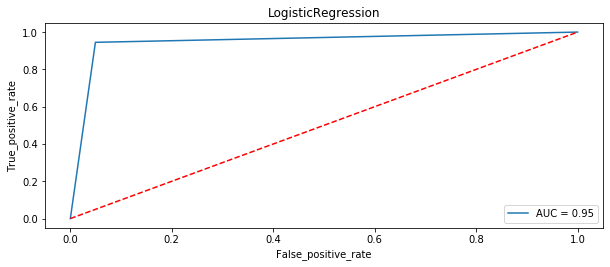

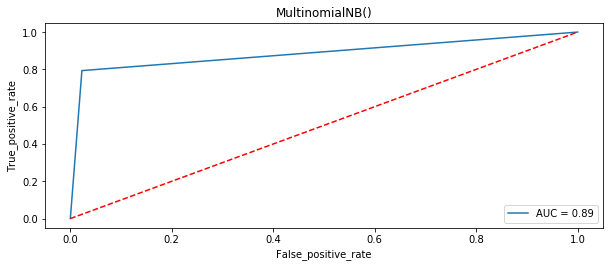

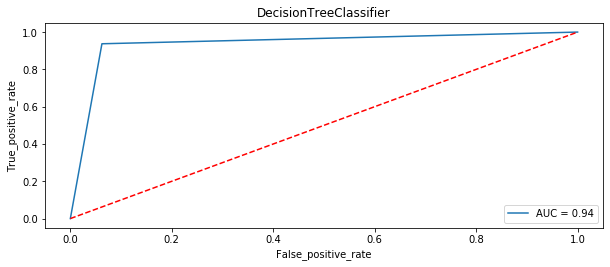

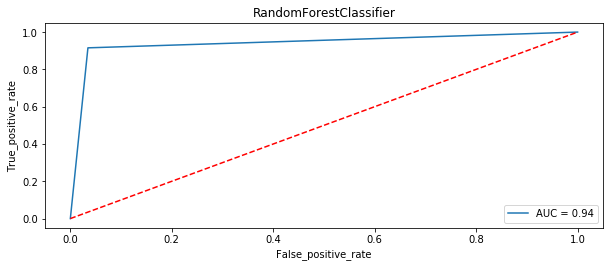

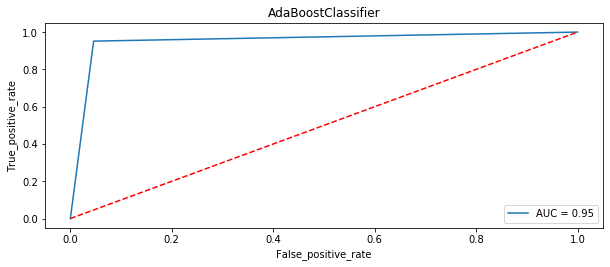

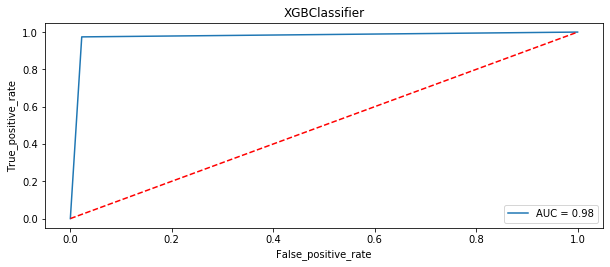

In [32]:
#     Lists to store model name, Learning score, Accuracy score, cross_val_score, Auc Roc score .
Model=[]
Score=[]
Acc_score=[]
cvs=[]
rocscore=[]
#            For Loop to Calculate Accuracy Score, Cross Val Score, Classification Report, Confusion Matrix

for name,model in models:
    print('***************************',name,'*****************************')
    print('\n')
    Model.append(name)
    print(model)
    print('\n')
    
     #        Now here I am calling a function which will calculate the max accuracy score for each model 
     #                               and return best random state.
    r_state=max_acc_score(model,x,y)
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=r_state,stratify=y)
    model.fit(x_train,y_train)
#..............Learning Score...........
    score=model.score(x_train,y_train)
    print('Learning Score : ',score)
    Score.append(score*100)
    y_pred=model.predict(x_test)
    acc_score=accuracy_score(y_test,y_pred)
    print('Accuracy Score : ',acc_score)
    Acc_score.append(acc_score*100)
#................Finding Cross_val_score..................    
    cv_score=cross_val_score(model,x,y,cv=10,scoring='roc_auc').mean()
    print('Cross Val Score : ', cv_score)
    cvs.append(cv_score*100)
    
#................Roc auc score...........................    
    false_positive_rate,true_positive_rate, thresholds=roc_curve(y_test,y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    print('roc auc score : ', roc_auc)
    rocscore.append(roc_auc*100)
    print('\n')
#................Classification Report...........................      
    print('Classification Report:\n',classification_report(y_test,y_pred))
    print('\n')
    
    print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
    print('\n')
    

    
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    plt.plot(false_positive_rate,true_positive_rate,label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True_positive_rate')
    plt.xlabel('False_positive_rate')
    print('\n\n')

In [33]:
# Making a Dataframe comprises of Differnt Calculated Scores :
result=pd.DataFrame({'Model': Model,'Learning Score': Score,'Accuracy Score': Acc_score,'Cross Val Score':cvs,
                     'Roc_Auc_curve':rocscore}) 
result.style.background_gradient(cmap='YlGnBu')

,Model,Learning Score,Accuracy Score,Cross Val Score,Roc_Auc_curve
0,LogisticRegression,96.9722,94.7825,98.8231,94.7823
1,MultinomialNB(),90.6482,88.5375,97.0614,88.5331
2,DecisionTreeClassifier,100,93.755,93.4876,93.755
3,RandomForestClassifier,100,94.044,98.8315,94.0428
4,AdaBoostClassifier,95.0661,95.2801,98.6768,95.2801
5,XGBClassifier,99.9381,97.5919,99.6001,97.5918


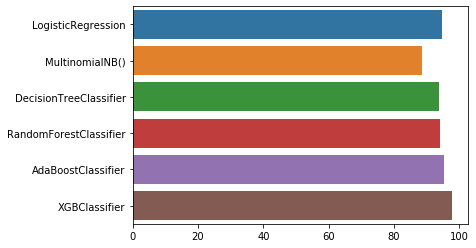

In [35]:
# visualisation of Accuracy Score
sns.barplot(y=Model,x=Acc_score)

## After all this process conclusion is that XGB Classifier and Adaboost Classifier and Random Forest Classifier are performing well in terms of Accuracy score, Cross val score and Roc_Auc score as compared to other models.   
## Thus Using Gridsearch CV for Hyperparameter tuning.

# Hyper Parameter Training

In [36]:
# Function for GridSearch
from sklearn.model_selection import GridSearchCV
def grid_cv(mod,parameters,scoring):
    clf = GridSearchCV(mod,parameters,scoring, cv=10)
    clf.fit(x,y)
    print(clf.best_params_)

In [37]:
#........Grid Search for LogisticRegression....
lr=LogisticRegression()
parameters={'C': [1, 10],"solver": ["liblinear"],'penalty' : ['l1', 'l2']}
grid_cv(lr,parameters,'f1')

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [38]:
# checking accuracy score(using max_acc_score function defined earlier) using best parameters which calculated from gridsearchCV
clf_lr = LogisticRegression(C=10,solver='liblinear',penalty='l2')
max_acc_score(clf_lr,x,y)

Max Accuracy Score corresponding to Random State  75 is: 0.9613100016053941




75

In [39]:
#.......Grid Search for RandomForestClassifier.....
rf=RandomForestClassifier()
parameters={'n_estimators': [100,200,500],'max_features': ['auto','sqrt', 'log2']}
grid_cv(rf,parameters,'f1')

{'max_features': 'auto', 'n_estimators': 500}


In [45]:
# checking accuracy score(using max_acc_score function defined earlier) using best parameters which calculated from gridsearchCV
clf_rf = RandomForestClassifier(n_estimators=500,max_features='auto')
max_acc_score(clf_rf,x,y)

Max Accuracy Score corresponding to Random State  53 is: 0.9510354792101461




53

## After all this process conclusion of Hyper Parameter is that Random Forest Classifier is giving accuracy of 95.10%, but XGB Classifier is giving an accuracy of 97% without tuning. So now I am making a final model using XGB Classifier.

# Final Model

In [50]:
# Using XGBClassifier for final model...
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=83,test_size=.30,stratify=y)
XG=XGBClassifier()
XG.fit(x_train,y_train)
XG.score(x_train,y_train)
XGpred=XG.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,XGpred))
print('Confusion Matrix:',confusion_matrix(y_test,XGpred))
print('Classification Report:','\n',classification_report(y_test,XGpred))

Accuracy Score: 0.9759190881361374
Confusion Matrix: [[3046   70]
 [  80 3033]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      3116
           1       0.98      0.97      0.98      3113

    accuracy                           0.98      6229
   macro avg       0.98      0.98      0.98      6229
weighted avg       0.98      0.98      0.98      6229



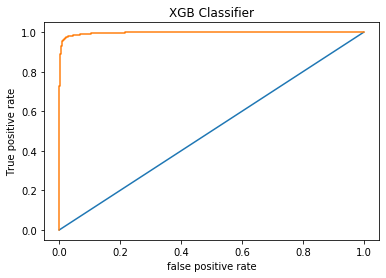

roc_auc_score =  0.9965913781578515


In [52]:
# Make predictions with probabilities
y_probs = XG.predict_proba(x_test)

# Keep the probabilites of the positive class only
y_probs = y_probs[:, 1]

# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Check the false positive rate
fpr
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr,label='XGB Classifier')
plt.xlabel('false positive rate')
plt.ylabel('True positive rate')
plt.title('XGB Classifier')
plt.show()
print('roc_auc_score = ',roc_auc_score(y_test, y_probs))

In [53]:
# Printing predicted values
test=pd.DataFrame(data=y_test,)
test['Predicted values']=XGpred
test
# On the lest side values are those which are taken by machine for test...

,0,Predicted values
0,1,1
1,1,1
2,0,0
3,0,0
4,1,1
...,...,...
6224,1,1
6225,1,1
6226,1,1
6227,0,0


In [54]:
# Saving the Predicted values in csv file
test.to_csv('Fake_news_Predict.csv') 

In [55]:
# Dumping Data in pickle file.
import joblib
joblib.dump(XG,'Fake_news_Predict.pkl')

['Fake_news_Predict.pkl']

## Steps Followed:

1) Data Analysis.            
2) Text Cleaning.           
3) Different models are used and machine is trained for each models to find Best Accuracy Score.       
4) Best parameters are found using Gridsearch cv and applied to the best models.       
5) AUC ROC Curves are made for each model.       
6) A Result table is made comprises of accuracy,cross_val,auc_roc scores of each model.        
7) XGB Classifier is used to train the model finally as it's accuracy score is best among the rest of the models.  
8) Predicted values are saved in Fake_news_Predict.csv file.   
9) Pickle file is named with Fake_news_Predict.pkl  

# End 